In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import time
from pathlib import Path


def load_image(image_path, transform):
    img = Image.open(image_path).convert('L')
    return transform(img)

def create_embedding_dicts(data_root, model, device='mps'):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    modalities = ['periocular', 'forehead', 'iris']
    splits = ['test']
    train_dict = {}
    test_dict = {}

    model = model.to(device)
    model.eval()

    for split in splits:
        print("Doing: ", split)
        target_dict = train_dict if split == 'train' else test_dict
        # Get person IDs from directory
        person_ids = [f"{i:03d}" for i in range(1, 248)]
        for person_id in person_ids:
            print("Person ", person_id)
            target_dict[person_id] = []  # List to store 10 embeddings
            # Iterate over poses (1 to 10)
            for pose_idx in range(1, 11):
                # Load images for all three modalities for this person and pose
                images = []
                for modality in modalities:
                    img_path = Path(data_root) / modality / split / person_id
                    pose_images = [f for f in sorted(os.listdir(img_path)) if f!='.DS_Store']
                    if len(pose_images) < pose_idx:
                        print(f"Warning: {img_path} has only {len(pose_images)} poses, expected at least {pose_idx}")
                        break
                    img_name = pose_images[pose_idx - 1]  # Select the pose_idx-th image
                    img_path = img_path / img_name
                    if not img_path.exists():
                        print(f"Warning: {img_path} does not exist")
                        break
                    img = load_image(img_path, transform).to(device)
                    images.append(img)
                else:  # Only execute if all images are found
                    # Pass three images to the model
                    with torch.no_grad():
                        embedding = model(
                            images[0].unsqueeze(0),  # periocular (add batch dim)
                            images[1].unsqueeze(0),  # forehead
                            images[2].unsqueeze(0)   # iris
                        )['joint'].squeeze(0).cpu()  # Remove batch dim
                    target_dict[person_id].append(embedding)
                if len(images) != 3:  # Skip if any image was missing
                    continue

    return train_dict, test_dict

In [5]:
data_root = './dataset2'

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

# from cvpr.MFA_ViT import MFA_ViT
# model = MFA_ViT(
#     img_size=128,           # Match the image size in your transform
#     patch_size=8,           # Standard patch size
#     in_chans=1,             # 1 channel for grayscale images
#     embed_dim=64,         # Embedding dimension
#     layer_depth=4,          # Standard transformer depth
#     num_heads=8,            # Number of attention heads
#     prompt_mode="deep",     # Using deep prompts
#     prompt_tokens=32,       # Number of prompt tokens
#     embedding_size=128      # Final embedding dimension for InfoNCE
# ).to(device)

# state_dict = torch.load('./cvpr/best_model.pt')
# model.load_state_dict(state_dict)
# model.eval()

from cnn_transformer.model_mpt import BiometricModel
model = BiometricModel(embedding_dim=256)
state_dict = torch.load('./cnn_transformer/model_latest_mpt_best.pt')
model.load_state_dict(state_dict)
model.eval()


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(total_params/1e6, trainable_params/1e6)

# train_dict, test_dict = create_embedding_dicts(data_root, model, device)

2025-05-17 02:38:57.375466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-17 02:38:58.080147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14.0576 14.0576


In [9]:
def evaluate_rank_k(test_dict, gallery_size=5, k=1, device='cuda'):
    """
    Evaluate rank-k recognition accuracy using cosine similarity.
    
    Args:
        test_dict: Dictionary with person IDs as keys and lists of embeddings as values
        gallery_size: Number of poses to use as gallery (remaining used as probe)
        k: The rank-k accuracy to compute (e.g., k=1 for rank-1, k=5 for rank-5)
        device: Device to perform calculations on
    
    Returns:
        Rank-k recognition rate
    """
    correct = 0
    total = 0
    
    # Convert embeddings to tensors and prepare gallery and probe sets
    gallery_embeddings = []
    gallery_labels = []
    probe_embeddings = []
    probe_labels = []
    
    for person_id, embeddings in test_dict.items():
        if len(embeddings) < gallery_size + 1:
            print(f"Skipping person {person_id} with only {len(embeddings)} embeddings")
            continue
            
        # Use first gallery_size embeddings as gallery
        for i in range(gallery_size):
            gallery_embeddings.append(embeddings[i])
            gallery_labels.append(person_id)
            
        # Use remaining embeddings as probe
        for i in range(gallery_size, len(embeddings)):
            probe_embeddings.append(embeddings[i])
            probe_labels.append(person_id)
    
    gallery_tensor = torch.stack(gallery_embeddings).to(device)
    probe_tensor = torch.stack(probe_embeddings).to(device)
    
    # Normalize embeddings for cosine similarity
    gallery_tensor = F.normalize(gallery_tensor, p=2, dim=1)
    probe_tensor = F.normalize(probe_tensor, p=2, dim=1)
    
    print(f"Gallery size: {len(gallery_tensor)} embeddings")
    print(f"Probe size: {len(probe_tensor)} embeddings")
    
    # Calculate similarities in batches to avoid OOM
    batch_size = 100
    correct = 0
    total = len(probe_tensor)
    
    with torch.no_grad():
        for i in tqdm(range(0, len(probe_tensor), batch_size)):
            batch_end = min(i + batch_size, len(probe_tensor))
            batch_probe = probe_tensor[i:batch_end]
            
            # Calculate cosine similarity between probe and gallery
            similarities = torch.mm(batch_probe, gallery_tensor.t())
            
            # Get the indices of top-k highest similarities
            _, indices = torch.topk(similarities, k=k, dim=1)
            
            # Check if the correct match is in top-k predictions
            for j in range(len(batch_probe)):
                probe_person = probe_labels[i + j]
                predicted_persons = [gallery_labels[idx.item()] for idx in indices[j]]
                
                if probe_person in predicted_persons:
                    correct += 1
    
    # Calculate rank-k recognition rate
    rank_k_rate = correct / total if total > 0 else 0
    return rank_k_rate, correct, total

# Add this code after loading the model and creating embeddings
print("Evaluating rank-k recognition performance...")

# Test with different gallery sizes and ranks
gallery_sizes = [8]
ranks = [1, 2, 5]

for gallery_size in gallery_sizes:
    for k in ranks:
        rank_k_rate, c, t = evaluate_rank_k(test_dict, gallery_size=gallery_size, k=k, device=device)
        print(f"Rank-{k} recognition rate with gallery size {gallery_size}: {rank_k_rate:.4f} ({rank_k_rate*100:.2f}%) {c}/{t}")


Evaluating rank-k recognition performance...
Skipping person 052 with only 8 embeddings
Skipping person 212 with only 4 embeddings
Gallery size: 1960 embeddings
Probe size: 488 embeddings


100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 882.75it/s]


Rank-1 recognition rate with gallery size 8: 0.7807 (78.07%) 381/488
Skipping person 052 with only 8 embeddings
Skipping person 212 with only 4 embeddings
Gallery size: 1960 embeddings
Probe size: 488 embeddings


100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 558.09it/s]


Rank-2 recognition rate with gallery size 8: 0.8607 (86.07%) 420/488
Skipping person 052 with only 8 embeddings
Skipping person 212 with only 4 embeddings
Gallery size: 1960 embeddings
Probe size: 488 embeddings


100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 269.35it/s]

Rank-5 recognition rate with gallery size 8: 0.9201 (92.01%) 449/488


In [16]:

def calculate_distances(test_dict):
    """Calculate genuine and impostor distances."""
    genuine_distances = []
    impostor_distances = []
    
    person_ids = list(test_dict.keys())
    print(f"Processing {len(person_ids)} identities...")
    
    for i, person1 in tqdm(enumerate(person_ids), total=len(person_ids)):
        embeddings1 = test_dict[person1]
        # Normalize embeddings
        embeddings1 = [F.normalize(emb, p=2, dim=0) for emb in embeddings1]
        
        # Calculate genuine distances (same person, different poses)
        num_embeddings = len(embeddings1)
        for j in range(num_embeddings):
            for k in range(j + 1, num_embeddings):
                dist = torch.dist(embeddings1[j], embeddings1[k]).item()
                genuine_distances.append(dist)
        
        # Calculate impostor distances (different persons)
        for person2 in person_ids[i + 1:]:
            embeddings2 = test_dict[person2]
            embeddings2 = [F.normalize(emb, p=2, dim=0) for emb in embeddings2]
            for emb1 in embeddings1:
                for emb2 in embeddings2:
                    dist = torch.dist(emb1, emb2).item()
                    impostor_distances.append(dist)
    
    genuine_distances = np.array(genuine_distances)
    impostor_distances = np.array(impostor_distances)
    
    print(f"\nDistance Statistics:")
    print(f"Genuine pairs: {len(genuine_distances)}")
    print(f"Genuine distance - Mean: {genuine_distances.mean():.4f}, Std: {genuine_distances.std():.4f}")
    print(f"Impostor pairs: {len(impostor_distances)}")
    print(f"Impostor distance - Mean: {impostor_distances.mean():.4f}, Std: {impostor_distances.std():.4f}")
    
    return genuine_distances, impostor_distances

def calculate_tpr_fpr(genuine_distances, impostor_distances, threshold):
    """Calculate TPR and FPR at a given threshold."""
    # True Positive = Genuine pairs correctly classified as genuine (distance <= threshold)
    # False Positive = Impostor pairs incorrectly classified as genuine (distance <= threshold)
    tp = np.sum(genuine_distances <= threshold)
    fp = np.sum(impostor_distances <= threshold)
    
    # Total genuine pairs = P (Positive)
    # Total impostor pairs = N (Negative)
    P = len(genuine_distances)
    N = len(impostor_distances)
    
    tpr = tp / P if P > 0 else 0  # TPR = TP/P
    fpr = fp / N if N > 0 else 0  # FPR = FP/N
    
    return tpr, fpr

def calculate_eer(genuine_distances, impostor_distances):
    """Calculate the Equal Error Rate."""
    # Use more thresholds for better precision
    min_dist = min(genuine_distances.min(), impostor_distances.min())
    max_dist = max(genuine_distances.max(), impostor_distances.max())
    thresholds = np.linspace(min_dist, max_dist, 1000)
    
    best_eer = float('inf')
    best_threshold = None
    
    for threshold in thresholds:
        tpr, fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
        far = fpr
        frr = 1 - tpr
        
        # EER is the point where FAR = FRR
        if abs(far - frr) < best_eer:
            best_eer = abs(far - frr)
            best_threshold = threshold
            if abs(far - frr) < 1e-7:  # Found exact match
                break
    
    final_tpr, final_fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, best_threshold)
    eer = (1 - final_tpr + final_fpr) / 2
    
    return eer, best_threshold


# Evaluate the model
print("Calculating distances...")
genuine_distances, impostor_distances = calculate_distances(test_dict)

print("Calculating EER...")
eer, eer_threshold = calculate_eer(genuine_distances, impostor_distances)
print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

# Calculate TPR at different distance thresholds
distance_thresholds = [0.5]  # Example distance thresholds
for threshold in distance_thresholds:
    tpr, fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
    print(f"At threshold {threshold:.2f}:")
    print(f"  TPR: {tpr:.4f}")
    print(f"  FPR: {fpr:.4f}")

# Plot ROC curve
thresholds = np.linspace(0, max(np.max(genuine_distances), np.max(impostor_distances)), 100)
tpr_list = []
fpr_list = []

for threshold in thresholds:
    tpr, fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr_list, tpr_list)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.close()


Calculating distances...
Processing 247 identities...


100%|███████████████████████████████████████████████████████████| 247/247 [00:12<00:00, 19.20it/s]



Distance Statistics:
Genuine pairs: 11041
Genuine distance - Mean: 0.3348, Std: 0.1330
Impostor pairs: 3013529
Impostor distance - Mean: 0.8061, Std: 0.1736
Calculating EER...
Equal Error Rate (EER): 0.0753
EER Threshold: 0.5466
At threshold 0.50:
  TPR: 0.8799
  FPR: 0.0450


In [28]:
len(genuine_distances), len(impostor_distances)

(11041, 3013529)

Computing t-SNE projection...
t-SNE visualization saved as 'embeddings_tsne.png'


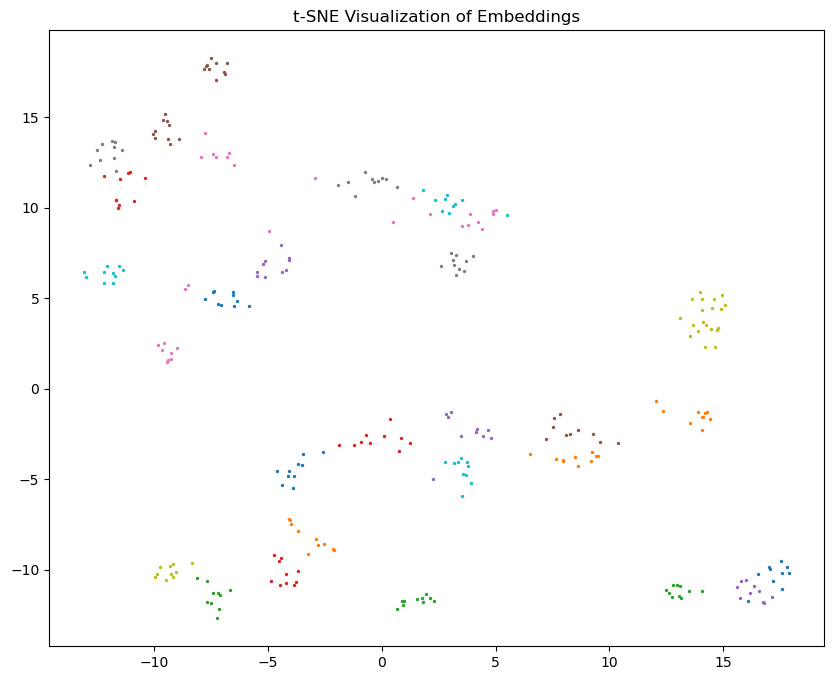

In [29]:
def visualize_embeddings(test_dict, num_persons=30):
    # Collect embeddings and labels
    embeddings = []
    labels = []
    
    # Take first 30 persons
    for i, (person_id, person_embeddings) in enumerate(test_dict.items()):
        if i >= num_persons:
            break
        embeddings.extend(person_embeddings)
        labels.extend([i] * len(person_embeddings))
    
    # Convert to numpy arrays
    embeddings_np = torch.stack(embeddings).numpy()
    
    # Apply t-SNE
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings_np)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_persons):
        indices = [j for j, label in enumerate(labels) if label == i]
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], label=f"Person {i+1}", s=2)
    
    plt.title("t-SNE Visualization of Embeddings")
    plt.savefig("embeddings_tsne.png")
    print("t-SNE visualization saved as 'embeddings_tsne.png'")

# Uncomment to visualize embeddings
visualize_embeddings(test_dict)